### pip installations

In [322]:
import numpy as np
from humanize import metric
from scipy.spatial.distance import cdist
from typing import List, Dict
import importlib

import numpy as np
import ot  # POT library for Optimal Transport
# import starfysh
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes
from scipy.spatial.distance import cdist
# !pip install starfysh
# !pip install pandas
# !pip install scanpy
# !pip install histomicstk
# !pip install --upgrade pip setuptools wheel
# !pip install pyvips --use-pep517
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import bar_nick_utils

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, get_cell_representations_as_archetypes, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal

# computationally figure out which ones are best
np.random.seed(8)

### reading in data

In [210]:
adata = sc.read("data/totalVI/spleen_lymph_cite_seq.h5ad")
adata = adata[adata.obs['batch'] == f'SLN111-D1']
# order adata by minor cell types
# a = adata.obsm['protein_expression'].iloc[0,0]
# print(a)
# a = adata.obsm['protein_expression'].iloc[0,0]
# print(a)

# adata.obsm['protein_expression'] = adata.obsm['protein_expression'].iloc[adata.obs['cell_types'].argsort(),:]
# take subsampel of adata
fraction = 0.25
sc.pp.subsample(adata, fraction=fraction)
adata = adata[adata.obs['cell_types'].argsort(),:]

# adata.obsm['protein_expression'].columns.tolist()

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [211]:
adata.obsm['protein_expression'].values.max()

6795.0

In [212]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

/tmp/ipykernel_14763/1684217180.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))


In [213]:
# filtering cell types with low quantity
# need to add this filtering step to synthtic_data_generation.ipynb

# mask = adata.obs['major_cell_types'].isin(['Plasmacytoid dendritic cells', 'Red blood cells', 'Dendritic cells'])
# adata = adata[~mask]


In [214]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        1098
CD4 T           506
CD8 T           333
cDCs             54
T cells          51
Treg             35
Macrophages      25
NK               24
Monocytes        22
Neutrophils      19
pDCs             11
RBC               6
Name: count, dtype: int64

### preprocessing RNA protein

In [215]:
adata.X.todense()[:100, :10]
print("Contains NaN:", np.isnan(adata.X.todense()).any())
print("Contains Inf:", np.isinf(adata.X.todense()).any())


Contains NaN: False
Contains Inf: False


In [216]:
# adata_prot = preprocess_protein(adata_prot)
# (adata_rna.X.sum(0).T)
# sc.pp.normalize_total(adata_prot)
# make the X sparse mat integers
# adata.X = adata.X.astype(int)
#

In [217]:
# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=20)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=500, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
print(f"Selected {adata.shape[1]} highly variable genes.")

# PCA after selecting highly variable genes
sc.pp.pca(adata)
print(
    f"Variance ratio after highly variable gene selection PCA: {adata.uns['pca']['variance_ratio'][:10].sum():.4f}")



Selected 500 highly variable genes.
Variance ratio after highly variable gene selection PCA: 0.9678


/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [218]:
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
sc.pp.pca(adata_rna)
print(adata_rna.uns['pca']['variance_ratio'][:10].sum())
adata_rna = preprocess_rna(adata_rna)
sc.pp.pca(adata_rna)
print(adata_rna.uns['pca']['variance_ratio'][:10].sum())

adata_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_prot = preprocess_protein(adata_prot)
# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch
# larget_batch = adata_prot.obs['batch'].value_counts().idxmax()

0.96780795
Variance ratio after log transformation PCA: 0.5394
Variance ratio after normalization PCA: 0.4978
0.49777693
Variance ratio after PCA: 0.9304
Variance ratio after normalization PCA: 0.9298
Variance ratio after log transformation PCA: 0.6770


In [219]:
adata_prot.X

array([[2.4078395, 1.8008789, 0.6111203, ..., 0.9876765, 0.9876765,
        3.3604558],
       [3.6859663, 1.5358648, 0.7953037, ..., 1.5358648, 1.9566478,
        2.7460756],
       [2.9232914, 2.188418 , 1.6865108, ..., 0.6313361, 0.6313361,
        3.173173 ],
       ...,
       [3.047009 , 0.       , 2.0391524, ..., 1.4683458, 1.7939355,
        3.2921584],
       [2.977518 , 1.9758855, 1.5151905, ..., 1.8445783, 1.2982049,
        2.5971937],
       [3.2064073, 1.6690857, 1.853817 , ..., 1.4423165, 2.0096853,
        2.707968 ]], dtype=float32)

In [220]:
adata = adata_prot

### analysis to get to scatter plot

In [221]:
np.cumsum(adata_prot.uns['pca']['variance_ratio'])



array([0.4394501 , 0.517392  , 0.5713479 , 0.598142  , 0.6150926 ,
       0.6310946 , 0.6448137 , 0.65686035, 0.66707283, 0.6769844 ,
       0.68531984, 0.6929387 , 0.700513  , 0.7078592 , 0.7147381 ,
       0.7208767 , 0.72687995, 0.73261726, 0.7379093 , 0.74312794,
       0.7481152 , 0.7530337 , 0.7578742 , 0.76262385, 0.7672947 ,
       0.77190053, 0.77642936, 0.78083616, 0.78519017, 0.78948575,
       0.7936972 , 0.7978919 , 0.8020176 , 0.806092  , 0.8101163 ,
       0.81408405, 0.8180031 , 0.82190424, 0.82575285, 0.82956094,
       0.8333419 , 0.83706707, 0.8407555 , 0.84439623, 0.8480026 ,
       0.85153806, 0.85506016, 0.85854155, 0.86194336, 0.8653429 ],
      dtype=float32)

In [222]:
max_possible_pca_dim_rna = min(adata_rna.X.shape[1], adata_rna.X.shape[0])
max_possible_pca_dim_prot = min(adata_prot.X.shape[1], adata_prot.X.shape[0])
sc.pp.pca(adata_rna, n_comps=max_possible_pca_dim_rna - 1)
sc.pp.pca(adata_prot, n_comps=max_possible_pca_dim_prot - 1)
# print explain ration var for both
# print(adata_prot.uns['pca']['variance_ratio'][:20].sum())
# print(adata_rna.uns['pca']['variance_ratio'][:20].sum())
# sc.pl.pca_variance_ratio(adata_prot)
# sc.pl.pca_variance_ratio(adata_rna)
# make PCA explain 90% of variance
cumulative_variance_ratio = np.cumsum(adata_rna.uns['pca']['variance_ratio'])
n_comps_90 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
sc.pp.pca(adata_rna, n_comps=n_comps_90)
print(f"Number of components explaining 90% of variance: {n_comps_90}")
sc.pp.pca(adata_prot)
cumulative_variance_ratio = np.cumsum(adata_prot.uns['pca']['variance_ratio'])
n_comps_90 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
sc.pp.pca(adata_prot, n_comps=n_comps_90)
print(f"Number of components explaining 90% of variance: {n_comps_90}")
print(np.cumsum(adata_prot.uns['pca']['variance_ratio']))
print(np.cumsum(adata_rna.uns['pca']['variance_ratio']))
# adata.uns['pca']['variance_ratio'][:10].sum()

Number of components explaining 90% of variance: 85
Number of components explaining 90% of variance: 33
[0.43944985 0.5173917  0.57134765 0.5981418  0.61509234 0.63109434
 0.6448135  0.6568602  0.66707265 0.67698425 0.68531966 0.6929385
 0.7005128  0.70785904 0.7147379  0.7208765  0.7268798  0.7326171
 0.73790914 0.74312776 0.748115   0.7530335  0.757874   0.76262367
 0.7672945  0.77190036 0.7764292  0.780836   0.78519    0.7894856
 0.793697   0.79789174 0.80201745]
[0.32045245 0.37521115 0.3995237  0.4194834  0.43659967 0.45090908
 0.46512285 0.47714975 0.48823807 0.49777767 0.5068566  0.51470757
 0.5221492  0.5292352  0.5356997  0.5420079  0.54796696 0.55388194
 0.55964136 0.5651696  0.57062805 0.57598597 0.58126837 0.58641857
 0.5915208  0.59653836 0.60139996 0.60621625 0.61097175 0.61568725
 0.62037337 0.6249563  0.6294752  0.63390535 0.6382605  0.6426069
 0.64692223 0.65111697 0.655246   0.6593151  0.6633547  0.6673339
 0.6712973  0.6752254  0.6791062  0.6829278  0.6867051  0.6904

In [223]:
archetype_list_protein = []
archetype_list_rna = []
converge = 1e-5
min_k = 7
max_k = 11
step_size = 2

evs = []
X_protein = adata_prot.obsm['X_pca'].T
total = (max_k - min_k) / step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and ev - evs[i - 1] < converge:
        print('early stopping')
        break
evs = []
X_rna = adata_rna.obsm['X_pca'].T

for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    if j > i:
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and ev - evs[j - 1] < converge:
        # early stopping
        print('early stopping')
        break
min_len = min([len(archetype_list_protein), len(archetype_list_rna)])
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]

100%|██████████| 2/2.0 [00:01<00:00,  1.37it/s]
100%|██████████| 2/2.0 [00:03<00:00,  1.79s/it]


In [224]:
adata_prot.X[:100, :10].max()

5.318462

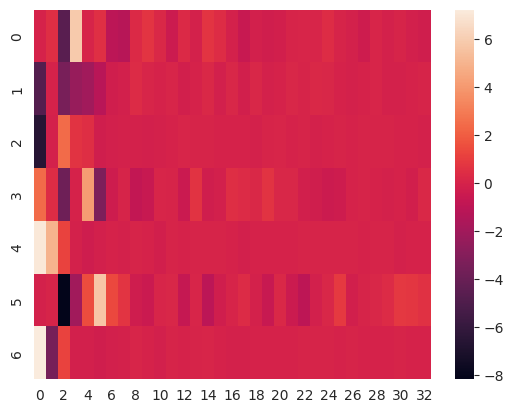

<Axes: >

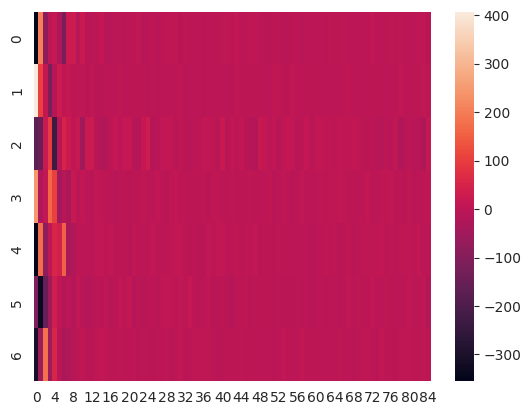

In [225]:
sns.heatmap(archetype_list_protein[0])
plt.show()
sns.heatmap(archetype_list_rna[0])

In [226]:
# send this for gene and protein as well as matching arrays over slack
# loop over prot and rna archetypes and get  weights for each loop over the archetypes
major_cell_types_list = sorted(list(set(adata_prot.obs['major_cell_types'])))
major_cell_types_amount_prot = [adata_prot.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                                major_cell_types_list]
major_cell_types_amount_rna = [adata_rna.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                               major_cell_types_list]
assert set(adata_rna.obs['major_cell_types']) == set(adata_prot.obs['major_cell_types'])
archetypes_prot_proportions, archetypes_ran_proportions = [], []

# weights_prot = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetype_list_protein[0])
# weights_rna = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetype_list_rna[0])
archetype_proportion_list = []

for archetypes_prot, archetypes_rna in tqdm(zip(archetype_list_protein, archetype_list_rna),
                                            total=len(archetype_list_protein)):
    weights_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot)
    weights_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], archetypes_rna)
    archetypes_dim = archetypes_prot.shape[1]
    archetype_num = archetypes_prot.shape[0]
    prot_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))), columns=major_cell_types_list)
    rna_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))), columns=major_cell_types_list)
    archetype_cell_proportions = np.zeros((archetype_num, len(major_cell_types_list)))
    row_argmax_prot = np.argmax(weights_prot, axis=1)
    row_argmax_rna = np.argmax(weights_rna, axis=1)
    for curr_archetype in range(archetype_num):
        df_rna = pd.DataFrame([weights_prot[:, curr_archetype], adata_rna.obs['major_cell_types'].values],
                              index=['weight', 'major_cell_types']).T
        df_prot = pd.DataFrame([weights_rna[:, curr_archetype], adata_prot.obs['major_cell_types'].values],
                               index=['weight', 'major_cell_types']).T
        df_rna = df_rna.groupby('major_cell_types')['weight'].sum()
        df_prot = df_prot.groupby('major_cell_types')['weight'].sum()
        df_rna = df_rna[major_cell_types_list]
        df_prot = df_prot[major_cell_types_list]
        # normalize by the amount of major cell types
        rna_arch_prop.loc[curr_archetype, :] = df_rna.values / major_cell_types_amount_rna
        prot_arch_prop.loc[curr_archetype, :] = df_prot.values / major_cell_types_amount_prot

    prot_arch_prop = (prot_arch_prop.T / prot_arch_prop.sum(1)).T
    prot_arch_prop = prot_arch_prop / prot_arch_prop.sum(0)
    rna_arch_prop = (rna_arch_prop.T / rna_arch_prop.sum(1)).T
    rna_arch_prop = rna_arch_prop / rna_arch_prop.sum(0)

    archetype_proportion_list.append([prot_arch_prop.copy(), rna_arch_prop.copy()])

100%|██████████| 2/2 [01:14<00:00, 37.15s/it]


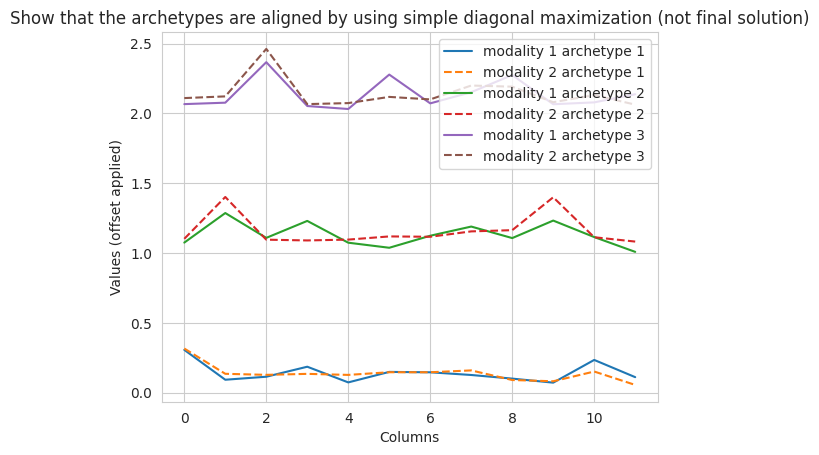

In [227]:
# normlize archetype_proportion_list cols
def nn(norm):
    norm = (norm.T / norm.sum(1)).T
    norm = norm / norm.sum(0)
    return norm


norm_1 = nn(archetype_proportion_list[0][0])
norm_2 = nn(archetype_proportion_list[0][1])
# sns.heatmap(reorder_rows_to_maximize_diagonal(norm_1.values)[0])
# plt.show()
# sns.heatmap(reorder_rows_to_maximize_diagonal(norm_2.values)[0])

new_order_1 = reorder_rows_to_maximize_diagonal(norm_1.values)[1]
new_order_2 = reorder_rows_to_maximize_diagonal(norm_2.values)[1]
new_order_2, new_order_1
archetype_proportion_list[0][1].iloc[new_order_2, :], archetype_proportion_list[0][0].iloc[new_order_1, :]
data1 = archetype_proportion_list[0][0].iloc[new_order_1, :].values
data2 = archetype_proportion_list[0][1].iloc[new_order_2, :].values
offset = 1
rows = 3
# major_cell_types_amount
for i in range(rows):
    y1 = data1[i] + i * offset
    y2 = data2[i] + i * offset
    plt.plot(y1, label=f'modality 1 archetype {i + 1}')
    plt.plot(y2, linestyle='--', label=f'modality 2 archetype {i + 1}')

# Add labels, legend, and title
plt.xlabel('Columns')
plt.ylabel('Values (offset applied)')
plt.title('Show that the archetypes are aligned by using simple diagonal maximization (not final solution)')
plt.legend()
plt.grid(True)
plt.show()

In [228]:

def match_rows(rna, protein, metric='cosine'):
    cost_matrix = cdist(rna, protein, metric=metric)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    n_archetypes = rna.shape[0]
    normalized_cost = total_cost / n_archetypes
    return row_ind, col_ind, normalized_cost, cost_matrix


def find_best_pair_by_row_matching(archetype_proportion_list, metric='cosine'):
    """
    Find the best index in the list by matching rows using linear assignment.

    Parameters:
    -----------
    archetype_proportion_list : list of tuples
        List where each tuple contains (rna, protein) matrices.
    metric : str, optional
        Distance metric to use ('euclidean' or 'cosine').

    Returns:
    --------
    best_num_or_archtypes_index : int
        Index of the best matching pair in the list.
    best_total_cost : float
        Total cost of the best matching.
    best_rna_archetype_order : np.ndarray
        Indices of RNA rows.
    best_protein_archetype_order : np.ndarray
        Indices of Protein rows matched to RNA rows.
    """
    best_num_or_archtypes_index = None
    best_total_cost = float('inf')
    best_rna_archetype_order = None
    best_protein_archetype_order = None

    for i, (rna, protein) in enumerate(archetype_proportion_list):
        rna = rna.values if hasattr(rna, 'values') else rna
        protein = protein.values if hasattr(protein, 'values') else protein

        assert rna.shape[1] == protein.shape[1], f"Mismatch in dimensions at index {i}."

        row_ind, col_ind, total_cost, _ = match_rows(rna, protein, metric=metric)
        print(f"Pair {i}: Total matching cost = {total_cost}")

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_num_or_archtypes_index = i
            best_rna_archetype_order = row_ind
            best_protein_archetype_order = col_ind

    return best_num_or_archtypes_index, best_total_cost, best_rna_archetype_order, best_protein_archetype_order


best_num_or_archtypes_index, best_total_cost, best_rna_archetype_order, best_protein_archetype_order = find_best_pair_by_row_matching(
    archetype_proportion_list, metric='cosine'
)

print("\nBest pair found:")
print(f"Best index: {best_num_or_archtypes_index}")
print(f"Best total matching cost: {best_total_cost}")
print(f"Row indices (RNA): {best_rna_archetype_order}")
print(f"Matched row indices (Protein): {best_protein_archetype_order}")


Pair 0: Total matching cost = 0.09831056337339741
Pair 1: Total matching cost = 0.1307531950314186

Best pair found:
Best index: 0
Best total matching cost: 0.09831056337339741
Row indices (RNA): [0 1 2 3 4 5 6]
Matched row indices (Protein): [5 2 0 1 6 3 4]


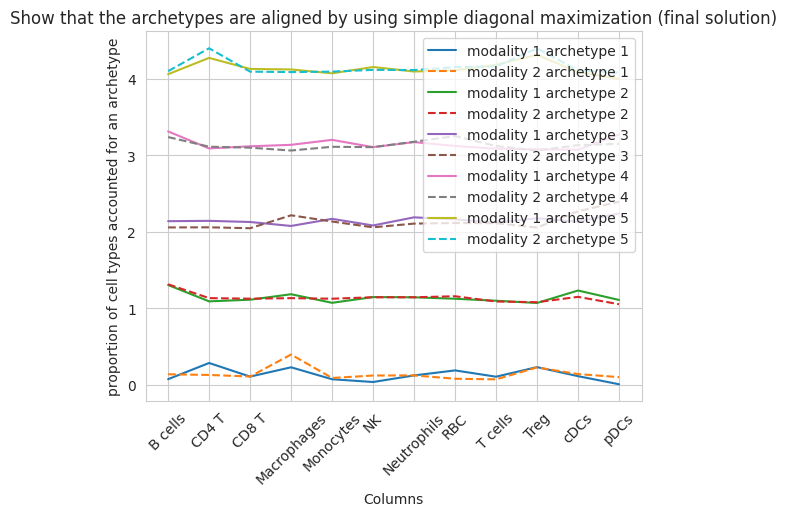

In [271]:
best_archetype_rna_prop = archetype_proportion_list[best_num_or_archtypes_index][0].iloc[best_rna_archetype_order,
                          :].reset_index(drop=True)
best_archetype_prot_prop = archetype_proportion_list[best_num_or_archtypes_index][1].iloc[best_protein_archetype_order,
                           :].reset_index(drop=True)
data1 = best_archetype_rna_prop
data2 = best_archetype_prot_prop
offset = 1
rows = 5
for i in range(rows):
    y1 = data1.iloc[i] + i * offset
    y2 = data2.iloc[i] + i * offset
    plt.plot(y1, label=f'modality 1 archetype {i + 1}')
    plt.plot(y2, linestyle='--', label=f'modality 2 archetype {i + 1}')
plt.xlabel('Columns')
plt.ylabel('proportion of cell types accounted for an archetype')
plt.title('Show that the archetypes are aligned by using simple diagonal maximization (final solution)')
plt.legend()
# rotate x labels
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



Text(0.5, 1.0, 'show overlap of cell types in archetypes')

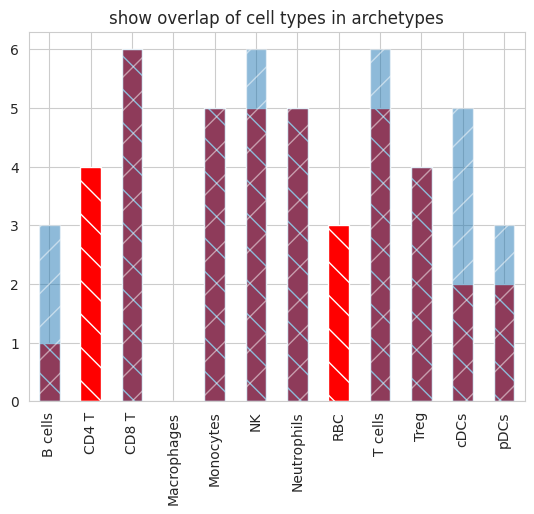

In [230]:
best_archetype_rna_prop.idxmax(axis=0).index, (best_archetype_prot_prop.idxmax(axis=0).index)
best_archetype_rna_prop.values.argmax(0), best_archetype_prot_prop.values.argmax(0)
best_archetype_rna_prop.values.argmax(0), best_archetype_rna_prop.idxmax(axis=0)
best_archetype_prot_prop.idxmax(axis=0).plot(kind='bar', color='red', hatch='\\')
best_archetype_rna_prop.idxmax(axis=0).plot(kind='bar', alpha=0.5, hatch='/')
plt.title('show overlap of cell types in archetypes')


Optimal normalized matching cost: 0.0983


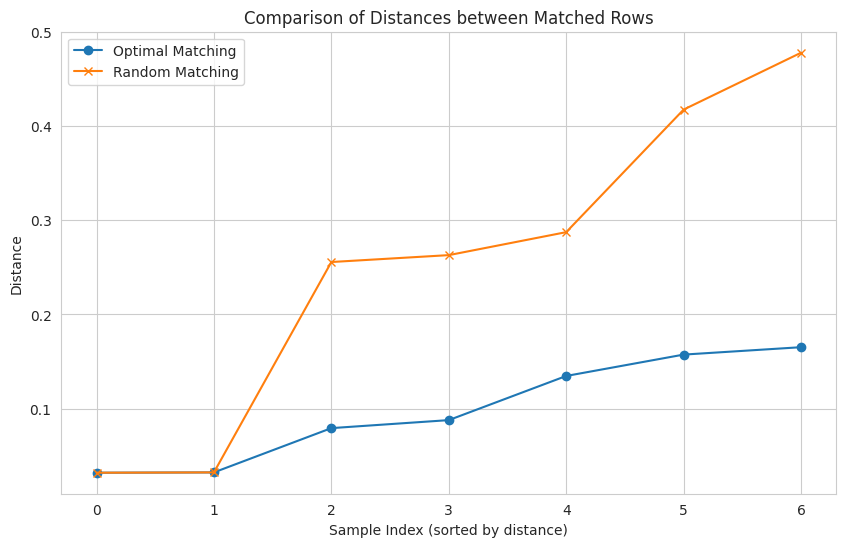

Average random matching cost over 100 trials: 0.2622
Standard deviation: 0.0445


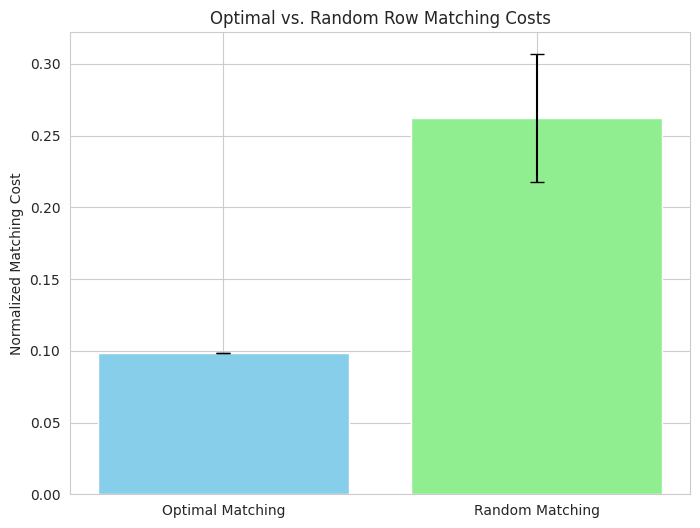

In [231]:


def compute_random_matching_cost(rna, protein, metric='cosine'):
    """Compute normalized cost and distances for a random row assignment."""
    n_samples = rna.shape[0]
    random_indices = np.random.permutation(n_samples)
    protein_random = protein[random_indices]

    if metric == 'euclidean':
        distances = np.linalg.norm(rna - protein_random, axis=1)
    elif metric == 'cosine':
        # Normalize rows to compute cosine similarity
        rna_norm = rna / np.linalg.norm(rna, axis=1, keepdims=True)
        protein_random_norm = protein_random / np.linalg.norm(protein_random, axis=1, keepdims=True)
        cosine_similarity = np.sum(rna_norm * protein_random_norm, axis=1)
        distances = 1 - cosine_similarity  # Cosine distance
    else:
        raise ValueError("Unsupported metric. Use 'euclidean' or 'cosine'.")

    normalized_cost = np.sum(distances) / n_samples
    return normalized_cost, distances


def compare_matchings(archetype_proportion_list, metric='cosine', num_trials=100):
    """Compare optimal matching cost with average random matching cost and plot norms."""
    # Extract the best pair based on optimal matching
    best_cost = float('inf')
    for i, (rna, protein) in enumerate(archetype_proportion_list):
        rna = rna.values if hasattr(rna, 'values') else rna
        protein = protein.values if hasattr(protein, 'values') else protein
        row_ind, col_ind, cost, cost_matrix = match_rows(rna, protein, metric)
        if cost < best_cost:
            best_cost = cost
            best_rna, best_protein = rna, protein
            best_rna_archetype_order, best_protein_archetype_order = row_ind, col_ind
            best_cost_matrix = cost_matrix
    print(f"Optimal normalized matching cost: {best_cost:.4f}")

    # Compute distances for the optimal matching
    optimal_distances = best_cost_matrix[best_rna_archetype_order, best_protein_archetype_order]

    # Compute distances for a single random matching
    random_cost, random_distances = compute_random_matching_cost(best_rna, best_protein, metric)

    # Visualization of distances
    n_samples = best_rna.shape[0]
    indices = np.arange(n_samples)

    plt.figure(figsize=(10, 6))
    plt.plot(indices, np.sort(optimal_distances), label='Optimal Matching', marker='o')
    plt.plot(indices, np.sort(random_distances), label='Random Matching', marker='x')
    plt.xlabel('Sample Index (sorted by distance)')
    plt.ylabel('Distance')
    plt.title('Comparison of Distances between Matched Rows')
    plt.legend()
    plt.show()

    # Compute average random matching cost over multiple trials
    random_costs = []
    for _ in range(num_trials):
        cost, _ = compute_random_matching_cost(best_rna, best_protein, metric)
        random_costs.append(cost)
    avg_random_cost = np.mean(random_costs)
    std_random_cost = np.std(random_costs)
    print(f"Average random matching cost over {num_trials} trials: {avg_random_cost:.4f}")
    print(f"Standard deviation: {std_random_cost:.4f}")

    # Bar plot of normalized matching costs
    labels = ['Optimal Matching', 'Random Matching']
    costs = [best_cost, avg_random_cost]
    errors = [0, std_random_cost]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, costs, yerr=errors, capsize=5, color=['skyblue', 'lightgreen'])
    plt.ylabel('Normalized Matching Cost')
    plt.title('Optimal vs. Random Row Matching Costs')
    plt.show()


# Example usage
# archetype_proportion_list should be a list of (rna_matrix, protein_matrix) tuples
if plot_flag:
    compare_matchings(archetype_proportion_list, metric='cosine', num_trials=100)


In [232]:
# get all cells archtype vec and see how they match
# ordered_best_rna_archetype, ordered_best_protein_archetype = archetype_proportion_list[best_num_or_archtypes_index]
# weights = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], ordered_best_protein_archetype.T)
# ordered_best_rna_archetype, ordered_best_protein_archetype = archetype_proportion_list[best_num_or_archtypes_index]
# ordered_best_rna_archetype.shape
ordered_best_rna_archetype = archetype_list_rna[best_num_or_archtypes_index][best_rna_archetype_order, :]
ordered_best_protein_archetype = archetype_list_protein[best_num_or_archtypes_index][best_protein_archetype_order, :]
# best_archetype_rna.shape, best_archetype_prot.shape
rna_archetype_vecs = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], ordered_best_rna_archetype)
protein_archetype_vecs = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], ordered_best_protein_archetype)

# major_cell_types_amount 

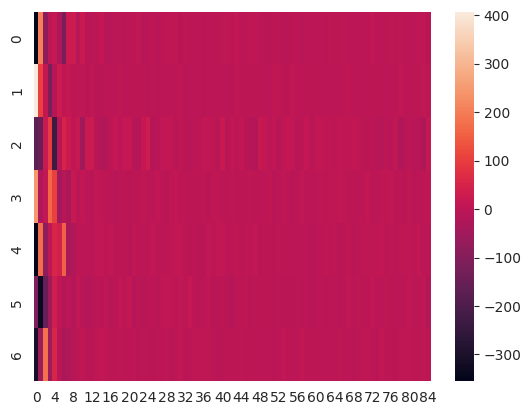

<Axes: >

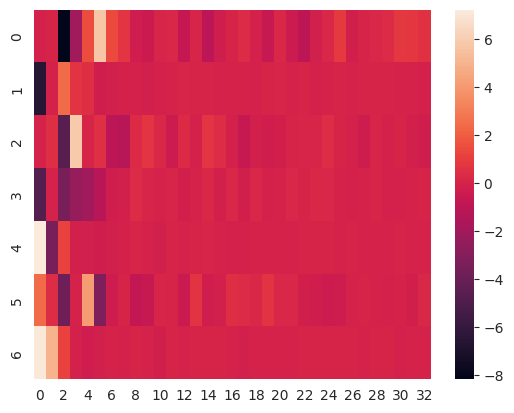

In [233]:
sns.heatmap(ordered_best_rna_archetype)
plt.show()
sns.heatmap(ordered_best_protein_archetype)

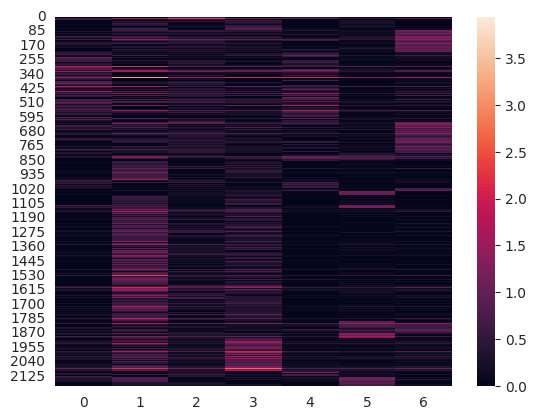

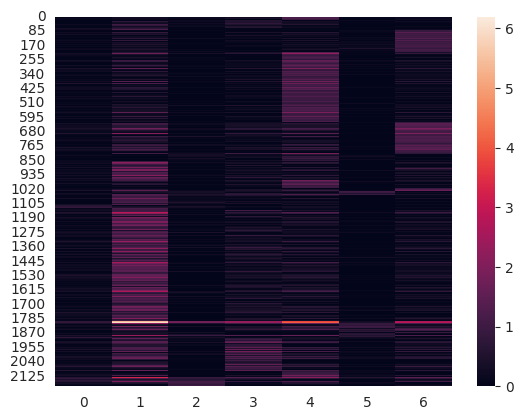

In [234]:
# rna_archetype_vecs = (rna_archetype_vecs -    rna_archetype_vecs.mean()) / rna_archetype_vecs.std()
# protein_archetype_vecs = (protein_archetype_vecs - protein_archetype_vecs.mean()) / protein_archetype_vecs.std()
sns.heatmap((rna_archetype_vecs))
plt.show()
sns.heatmap((protein_archetype_vecs))
plt.show()

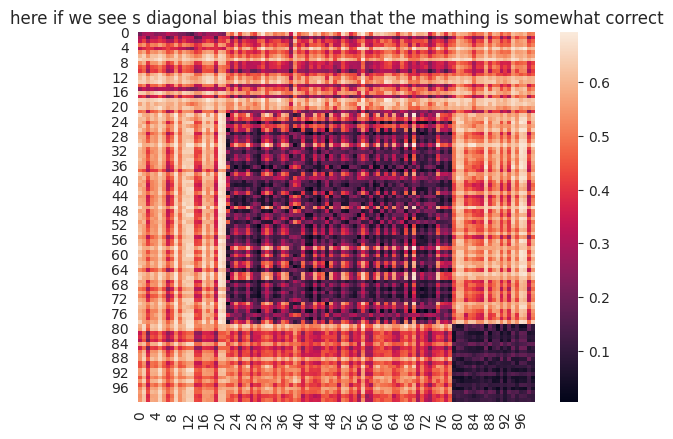

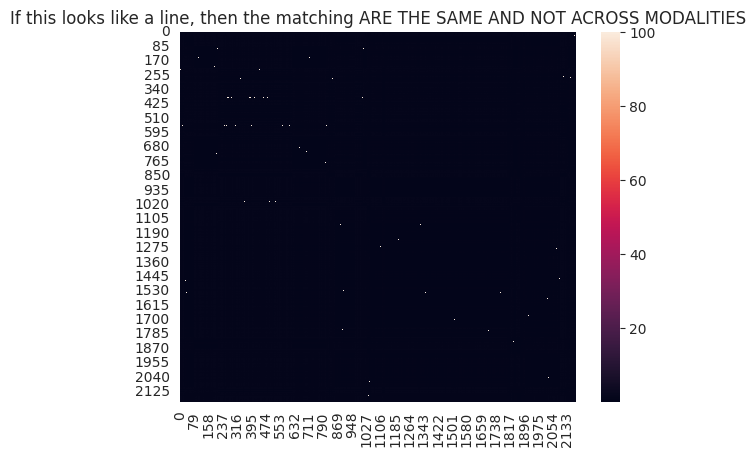

array([ 224,  429,  551, ..., 2146,  379,  816])

In [235]:

archetype_distances = cdist(rna_archetype_vecs,
                                                    protein_archetype_vecs, metric='cosine')
# adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
matching_cells = np.argmin(archetype_distances, axis=1)
# adata_prot_subset = adata_prot_subset[matching_cells] # this make sure that the cells are aligned!
# adata_rna_subset.obs['matching_protein_cells'] = matching_cells
sns.heatmap(np.log1p(archetype_distances[:100, :100]))
plt.title('here if we see s diagonal bias this mean that the mathing is somewhat correct')
plt.show()

# plt.plot(archetype_distances.argmin(axis=0))
plt.title('If this looks like a line, then the matching ARE THE SAME AND NOT ACROSS MODALITIES')
t = archetype_distances.copy()
t[archetype_distances.argmin(axis=0), range(len(archetype_distances.argmin(axis=0)))] = 100
sns.heatmap(t)
# sns.heatmap(np.log1p(archetype_distances[:100,:100]))
plt.show()

rna_archetype_vecs
len(archetype_distances.argmin(axis=0))
archetype_distances.argmin(axis=0)

In [236]:
(archetype_distances.argmin(axis=0)==np.arange(archetype_distances.argmin(axis=0).shape[0]).astype(int)).sum()


4

<Axes: >

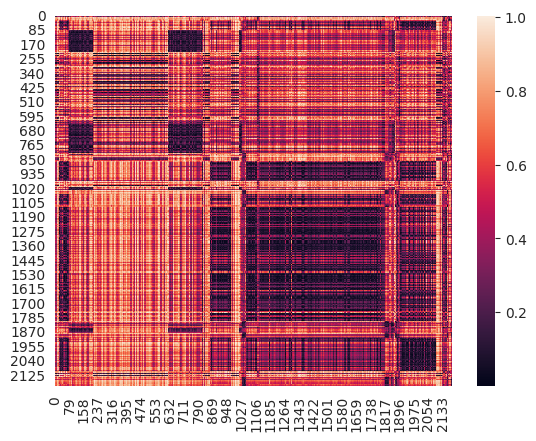

In [237]:
correlation_matrix = pd.DataFrame(
    cdist(rna_archetype_vecs,
                protein_archetype_vecs, metric='cosine')
)
correlation_matrix
sns.heatmap(correlation_matrix)

In [238]:
# np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))
# np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))

In [239]:
def plot_scatter(mtx1, mtx2,n_samples):
    pca = PCA(n_components=2)
    embeddings_combined = np.vstack((mtx1, mtx2))
    tsne_results = pca.fit_transform(embeddings_combined)
    # tsne_results = pca.fit_transform(embeddings_combined)

    labels = ['Dataset 1'] * n_samples + ['Dataset 2'] * n_samples
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Dataset'] = labels

    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Dataset', data=df)
    plt.title('t-SNE of Aligned Embeddings')
    plt.show()


In [240]:
# # weights = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes[-1].T)
# distances_array = []
# for arche in archetype:
#     distances = np.linalg.norm(adata_prot.obsm['X_pca']- arche, axis=1)
#     distances_array.append(distances)
# # np.linalg.norm(adata.obsm['X_pca'],archetype.T)
#     
# 
# # Columns: Cell 1 Cell 2 Cell 3 Cell 4
# # Row: anchor 
# # column, row distance from cell to anchor
# # we want minimum
# distances_array = np.array(distances_array)
# distances_array = distances_array.T
# row_argmin = np.argmin(distances_array, axis=1)
# adata.obs['archetype'] = row_argmin

### weights

In [241]:
archetype_list_protein[0].shape

(7, 33)

In [242]:
# send this for gene and protein as well as matching arrays over slack
# weights = get_cell_representations_as_archetypes_cvxpy(adata.obsm['X_pca'], archetype.T)
# weights_df = pd.DataFrame(weights)
# weights_df.to_csv("rna_weights.csv")
# row_argmax = np.argmax(weights, axis=1)
# adata.obs['corr_archetype'] = row_argmax
# len(set((adata.obs['major_cell_types'])))
archetype_matrix_rna = archetype_list_rna[best_num_or_archtypes_index][best_rna_archetype_order, :]
archetype_matrix_protein = archetype_list_protein[best_num_or_archtypes_index][best_protein_archetype_order, :]
cells_archetype_vec_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], archetype_matrix_rna)
cells_archetype_vec_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetype_matrix_protein)

In [243]:
# set(list(adata.obs['major_cell_types']))
(set(cell_type_mapping.keys())) == ((set(adata.obs['cell_types'])))

True

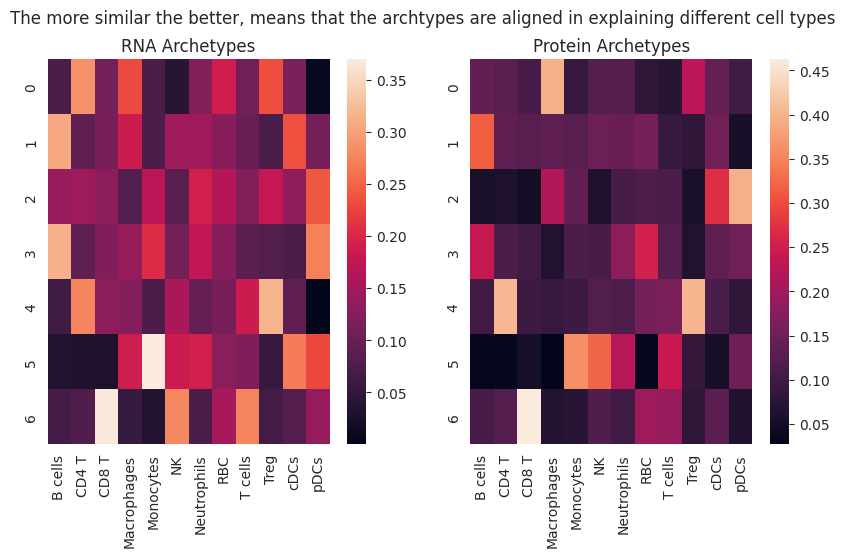

In [244]:
# protein_mapping = ['Red blood cells', 'Natural killer T cells', 'T cells-2', 'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']
# ordered_arch_rna  = archetype_proportion_list[best_num_or_archtypes_index][0].iloc[best_rna_archetype_order,:]
# ordered_arch_prot = archetype_proportion_list[best_num_or_archtypes_index][1].iloc[best_protein_archetype_order,:]
# plot both heatmaps as subplots, and add titel the more similar the better:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('RNA Archetypes')
plt.ylabel('Archetypes')
sns.heatmap(best_archetype_rna_prop)
plt.subplot(1, 2, 2)
plt.ylabel('Archetypes')
sns.heatmap(best_archetype_prot_prop)
plt.title('Protein Archetypes')
plt.suptitle('The more similar the better, means that the archtypes are aligned in explaining different cell types')
plt.show()
# errors = np.abs(ordered_arch_prot - ordered_arch_rna)
# random_error =np.abs(ordered_arch_prot - np.random.permutation(ordered_arch_rna))
# plt.plot(errors.values.flatten())
# plt.plot(random_error.values.flatten())
# plt.legend(['Error', 'Random Error'])
# plt.show()

In [245]:
gene_mapping = archetype_proportion_list[best_num_or_archtypes_index][0].columns[best_rna_archetype_order]
protein_mapping = archetype_proportion_list[best_num_or_archtypes_index][1].columns[best_protein_archetype_order]
for i in set(adata.obs['major_cell_types']):
    if i not in gene_mapping:
        print(i)
# print(len(protein_mapping))
# print(len(set(protein_mapping)))

cDCs
Treg
RBC
T cells
pDCs


In [295]:
ordered_best_protein_archetype.shape,archetype_list_protein[0].shape

((7, 33), (7, 33))

In [296]:
data_points_rna = adata_rna.obsm['X_pca']
data_points_prot = adata.obsm['X_pca']
samples_cell_types = list(pd.Categorical(adata_rna.obs['cell_types']))
samples_cell_types = list(pd.Categorical(adata_rna.obs['major_cell_types']))
# samples_cell_types = list(adata_rna.obs['corr_archetype'].astype(str)) #  to see the most correlated cells to each archetype
samples_cell_types_rna = list(
    np.argmax(get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], ordered_best_rna_archetype),
                axis=1).astype(np.str_))
samples_cell_types_prot = list(
    np.argmax(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], ordered_best_protein_archetype),
              axis=1).astype(np.str_))


Shape of data_points: (2184, 85)
Shape of archetype before any adjustment: (85, 7)
Transposing archetype array to match dimensions.
Shape of archetype after adjustment: (7, 85)


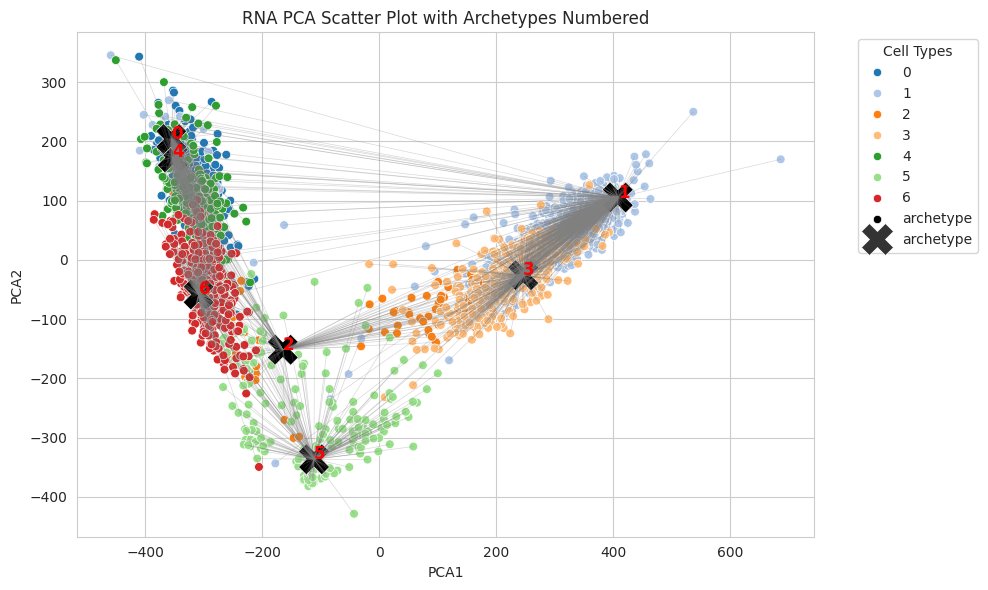

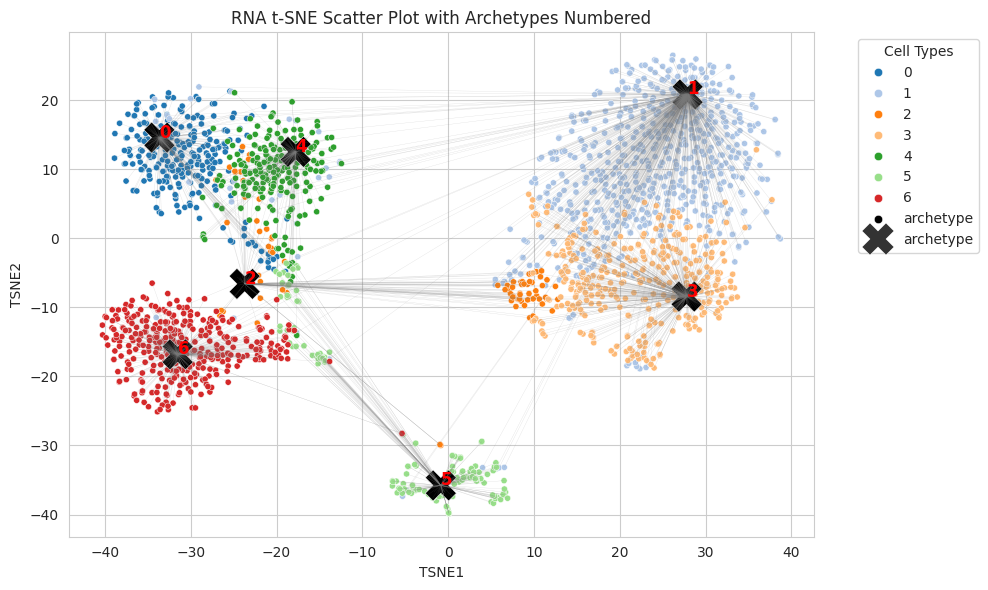

Shape of data_points: (2184, 33)
Shape of archetype before any adjustment: (7, 33)
Shape of archetype after adjustment: (7, 33)


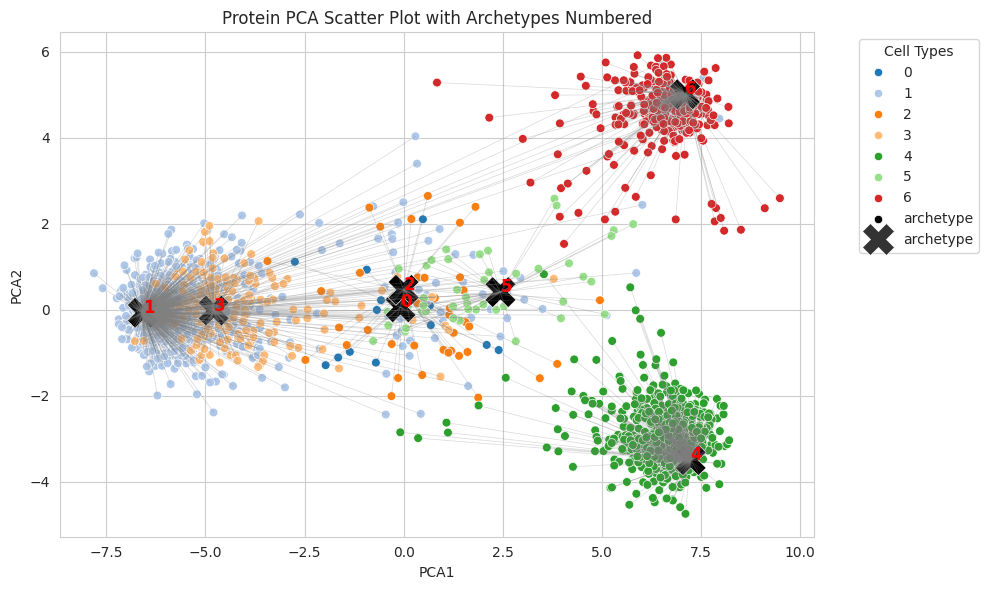

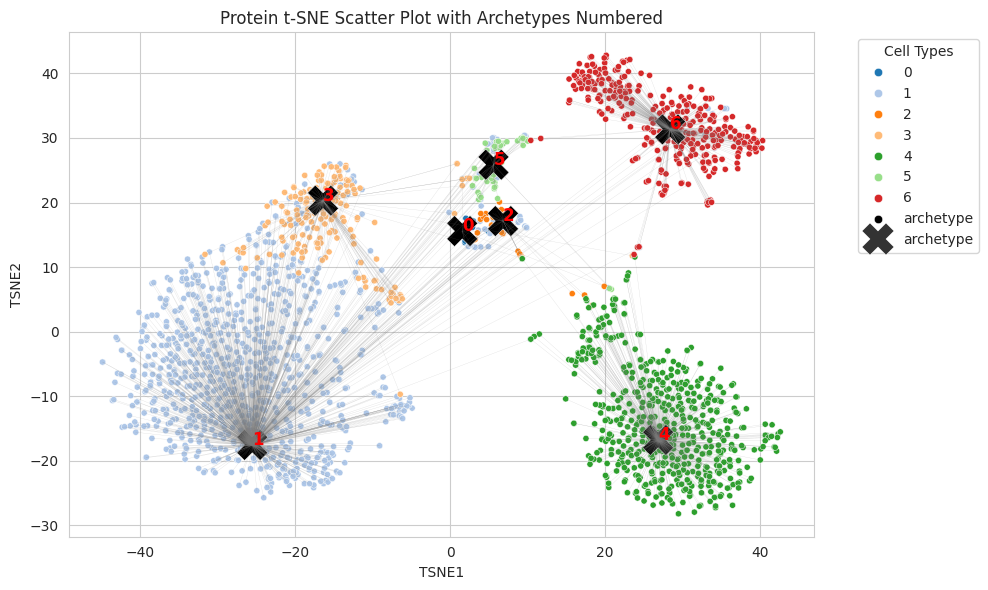

In [323]:
if True:
    num_samples = 5000
else:
    num_samples = len(samples_cell_types)
data_points_rna_plot = data_points_rna[:num_samples]
data_points_prot_plot = data_points_prot[:num_samples]
samples_cell_types_rna_plot = samples_cell_types_rna[:num_samples]
samples_cell_types_prot_plot = samples_cell_types_prot[:num_samples]



plot_archetypes(data_points_rna_plot, ordered_best_rna_archetype.T, samples_cell_types_rna_plot,modality='RNA')
plot_archetypes(data_points_prot_plot, ordered_best_protein_archetype, samples_cell_types_prot_plot,modality='Protein')


In [248]:


def evaluate_distance_metrics(A: np.ndarray, B: np.ndarray, metrics: List[str]) -> Dict:
    """
    Evaluates multiple distance metrics to determine which one best captures the similarity
    between matching rows in matrices A and B.

    Parameters:
    - A: np.ndarray of shape (n_samples, n_features)
    - B: np.ndarray of shape (n_samples, n_features)
    - metrics: List of distance metrics to evaluate

    Returns:
    - results: Dictionary containing evaluation metrics for each distance metric
    """
    results = {}

    for metric in metrics:
        print(f"Evaluating distance metric: {metric}")

        # Compute the distance matrix between rows of A and rows of B
        distances = cdist(A, B, metric=metric)

        # For each row i, get the distance between A[i] and B[i]
        matching_distances = np.diagonal(distances)

        # For each row i, get the distances between A[i] and all rows in B
        # Then compute the rank of the matching distance
        ranks = []
        for i in range(len(A)):
            row_distances = distances[i, :]
            # Get the rank of the matching distance
            # Rank 1 means the smallest distance
            rank = np.argsort(row_distances).tolist().index(i) + 1
            ranks.append(rank)

        ranks = np.array(ranks)
        total_samples = len(A)

        # Compute evaluation metrics
        num_correct_matches = np.sum(ranks == 1)
        percentage_correct = num_correct_matches / total_samples * 100
        mean_rank = np.mean(ranks)
        mrr = np.mean(1 / ranks)

        print(f"Percentage of correct matches (rank 1): {percentage_correct:.2f}%")
        print(f"Mean rank of matching rows: {mean_rank:.2f}")
        print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
        print("")

        results[metric] = {
            'percentage_correct': percentage_correct,
            'mean_rank': mean_rank,
            'mrr': mrr,
            'ranks': ranks
        }

    return results
metrics = ['euclidean', 'cityblock', 'cosine', 'correlation', 'chebyshev']

evaluate_distance_metrics(rna_archetype_vecs,protein_archetype_vecs,metrics)
a=1
protein_archetype_vecs.shape


Evaluating distance metric: euclidean
Percentage of correct matches (rank 1): 0.23%
Mean rank of matching rows: 666.98
Mean Reciprocal Rank (MRR): 0.0142

Evaluating distance metric: cityblock
Percentage of correct matches (rank 1): 0.41%
Mean rank of matching rows: 696.80
Mean Reciprocal Rank (MRR): 0.0157

Evaluating distance metric: cosine
Percentage of correct matches (rank 1): 0.32%
Mean rank of matching rows: 476.29
Mean Reciprocal Rank (MRR): 0.0151

Evaluating distance metric: correlation
Percentage of correct matches (rank 1): 0.18%
Mean rank of matching rows: 480.48
Mean Reciprocal Rank (MRR): 0.0130

Evaluating distance metric: chebyshev
Percentage of correct matches (rank 1): 0.32%
Mean rank of matching rows: 652.66
Mean Reciprocal Rank (MRR): 0.0141



(2184, 7)

In [249]:
# sc.pl.pca(adata, color='major_cell_types')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [250]:
# adata.obs['archetype'] = pd.Categorical(adata.obs['archetype'])
adata.obs['corr_archetype'] = pd.Categorical(adata.obs['corr_archetype'])
sc.pl.umap(adata, color=['major_cell_types', 'corr_archetype', 'cell_types'])


KeyError: 'corr_archetype'

In [668]:
sc.pl.pca(adata, color=['archetype', 'major_cell_types', 'corr_archetype', 'cell_types'])


KeyError: 'Could not find key archetype in .var_names or .obs.columns.'

<Figure size 2911.2x480 with 0 Axes>

In [ ]:
sc.pl.umap(adata, color='major_cell_types', title='Protein Major Cell Types')

In [669]:
sc.pl.umap(adata, color='cell_types', title='Protein Minor Cell Types')

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

could not find match for archetypes of length 7 
could not find match for archetypes of length 9 


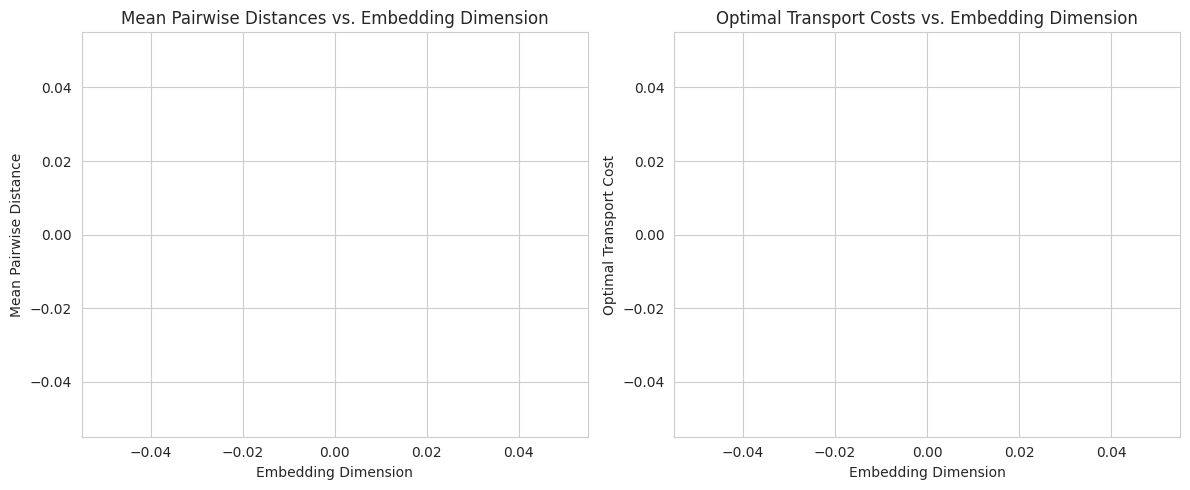

ValueError: attempt to get argmin of an empty sequence

In [670]:
embedding_dimensions = []  # Example dimensions from n to m
mean_pairwise_distances = []
ot_costs = []
metric = 'cosine'  # 'euclidean' or 'cosine'
# Number of samples in your datasets

# Loop over each embedding dimension
for archetypes_prot, archetypes_ran in (archetype_proportion_list):
    try:
        ds1_embeddings = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes_prot)
        ds2_embeddings = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetypes_ran)
    except:
        print(f'could not find match for archetypes of length {len(archetypes_prot)} ')
        continue

    embedding_dimensions.append(len(archetypes_prot))
    n_samples = ds1_embeddings.shape[0]
    # Standardize embeddings
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    ds1_embeddings = scaler1.fit_transform(ds1_embeddings)
    ds2_embeddings = scaler2.fit_transform(ds2_embeddings)

    # Step 2: Align Dimensions using Procrustes Analysis
    mtx1, mtx2, disparity = procrustes(ds1_embeddings, ds2_embeddings)
    # mtx1 and mtx2 are the aligned embeddings

    # Alternative: Align Dimensions using CCA
    # cca = CCA(n_components=dim)
    # ds1_embeddings_cca, ds2_embeddings_cca = cca.fit_transform(ds1_embeddings, ds2_embeddings)
    # Use ds1_embeddings_cca and ds2_embeddings_cca for further calculations

    # Step 3: Compute Pairwise Distances between corresponding samples
    pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1, metric='cosine')

    if metric == 'euclidean':
        pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1)
    elif metric == 'cosine':
        # Normalize rows to compute cosine similarity
        rna_norm = mtx1 / np.linalg.norm(mtx1, axis=1, keepdims=True)
        protein_random_norm = mtx2 / np.linalg.norm(mtx2, axis=1, keepdims=True)
        cosine_similarity = np.sum(rna_norm * protein_random_norm, axis=1)
        pairwise_distances = 1 - cosine_similarity  # Cosine distance
    else:
        raise ValueError("Unsupported metric. Use 'euclidean' or 'cosine'.")

    mean_distance = np.mean(pairwise_distances)
    mean_pairwise_distances.append(mean_distance)
    print(f"Mean Pairwise Distance: {mean_distance}")

    # Step 4: Compute Optimal Transport Cost
    # Create cost matrix between all samples (optional, since datasets are coupled)
    cost_matrix = cdist(mtx1, mtx2, metric='cosine')

    # Since datasets are coupled, create uniform distributions
    a = np.ones(n_samples) / n_samples
    b = np.ones(n_samples) / n_samples

    # Compute OT cost using Sinkhorn algorithm
    lambda_reg = 1e-3  # Entropic regularization parameter
    ot_cost = ot.sinkhorn2(a, b, cost_matrix, lambda_reg)
    ot_costs.append(ot_cost)
    print(f"Optimal Transport Cost: {ot_cost}")
    print("-" * 50)

# Step 5: Compare Embedding Spaces
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(embedding_dimensions, mean_pairwise_distances, marker='o')
plt.title('Mean Pairwise Distances vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Mean Pairwise Distance')

plt.subplot(1, 2, 2)
plt.plot(embedding_dimensions, ot_costs, marker='o', color='red')
plt.title('Optimal Transport Costs vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Optimal Transport Cost')

plt.tight_layout()
plt.show()

# Identify the best embedding space
best_dimension_index = np.argmin(mean_pairwise_distances)
best_embedding_dimension = embedding_dimensions[best_dimension_index]
print(f"The best embedding dimension based on mean pairwise distance is: {best_embedding_dimension}")

best_ot_index = np.argmin(ot_costs)
best_ot_dimension = embedding_dimensions[best_ot_index]
print(f"The best embedding dimension based on OT cost is: {best_ot_dimension}")
